# "Easy Street" Trading Bot

We are endeavoring to build a trading algorithm that will outperform a buy and hold strategy for the S&P 500, and evaluate whether or not this program could be used for trading alternative asset clasees that are correlated to the equity markets like crypto.

#### Project Steps
### Establishing a Baseline Performance

In this section, we will establish a baseline performance for the trading algorithm. To do so, we will complete the following steps:

1. Import the S&P 500 historical data into a Pandas DataFrame.

2. Generate trading signals using MACD and RSI technical indicators.

3. Backtest the trading signals to determine the profitability of the algorithm.

4. Split the data into training and testing datasets.

5. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

6. Review the classification report associated with the `SVC` model predictions. 

7. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

8. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

9. Write our conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with our GitHub repository.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [30]:
# Imports
import pandas as pd
import numpy as np
import io
import pytz
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
import pandas_ta as ta

---

## Establish a Baseline Performance

In this section, we will create our trading algorithm.


In [33]:
# Request historic hourly pricing data via finance.yahoo.com API
df = yf.Ticker('SPY').history(period='2y', interval = "1h")[['Close', 'Open', 'High', 'Volume', 'Low']]

# Review the DataFrame
df.head(20)

#note the data pulled from the API is already limited to only the hours the market is open

,Close,Open,High,Volume,Low
2020-04-06 13:30:00-04:00,261.670013,262.037903,262.954987,0,261.279999
2020-04-06 14:30:00-04:00,263.024994,261.660004,263.149994,18563887,261.399994
2020-04-06 15:30:00-04:00,264.970001,263.027008,267.000000,41939270,262.649994
2020-04-07 09:30:00-04:00,269.640015,274.149994,275.029999,53175098,269.279999
2020-04-07 10:30:00-04:00,271.200012,269.660004,271.260010,22407657,268.019989
2020-04-07 11:30:00-04:00,273.130005,271.166992,273.920013,19671160,271.029999
2020-04-07 12:30:00-04:00,272.149994,273.140015,273.269989,15062727,271.470001
2020-04-07 13:30:00-04:00,269.450012,272.170013,272.230011,16988326,268.519989
2020-04-07 14:30:00-04:00,265.980011,269.449799,269.929993,30029016,265.619995
2020-04-07 15:30:00-04:00,265.109985,265.989990,269.859985,30561741,264.890015


In [8]:
# Filter the date index and close columns
signals_df = df.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["actual_returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,actual_returns
2020-04-06 10:30:00-04:00,260.250000,0.002118
2020-04-06 11:30:00-04:00,262.130005,0.007224
2020-04-06 12:30:00-04:00,262.035004,-0.000362
2020-04-06 13:30:00-04:00,261.670013,-0.001393
2020-04-06 14:30:00-04:00,263.024994,0.005178


,Close,actual_returns
2022-04-05 13:30:00-04:00,452.950012,-0.002719
2022-04-05 14:30:00-04:00,451.400208,-0.003422
2022-04-05 15:30:00-04:00,451.100006,-0.000665
2022-04-06 09:30:00-04:00,445.964996,-0.011383
2022-04-06 09:57:16-04:00,445.980011,0.000034


<AxesSubplot:title={'center':'SPY - S&P 500 ETF 2 year return'}, ylabel='percent cumulative return'>

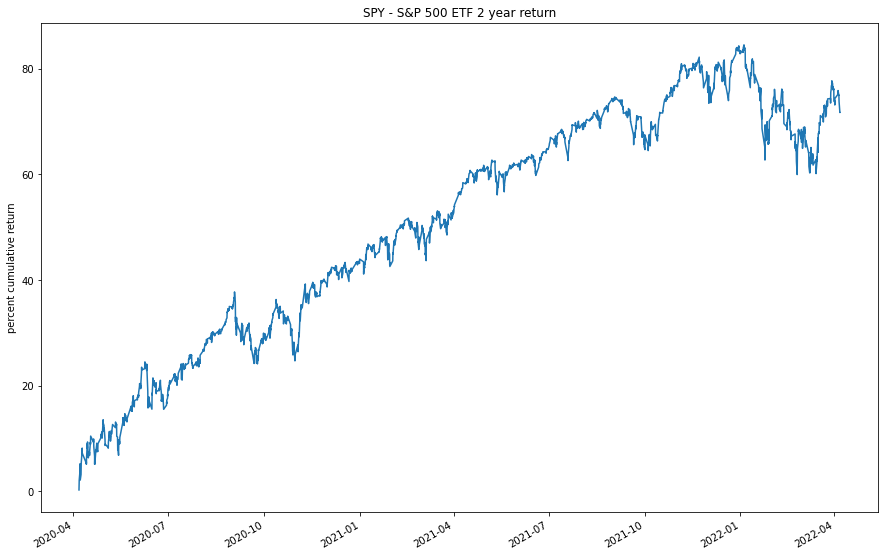

In [35]:
# Calculate the returns of the buy and hold S&P 500 strategy

# visualize the return of the S&P 500 over the past 2 years
((((1+signals_df["actual_returns"]).cumprod())-1)*100).plot(title="SPY - S&P 500 ETF 2 year return", ylabel="percent cumulative return", figsize = (15,10))

## Step 2: Generate trading signals using MACD and RSI

In [43]:
# Calculate MACD values using the pandas_ta library
signals_df.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)


# View result
display(signals_df.head(50))
display(signals_df.tail())

,Close,actual_returns,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
2020-04-06 10:30:00-04:00,260.250000,0.002118,NaN,NaN,NaN
2020-04-06 11:30:00-04:00,262.130005,0.007224,NaN,NaN,NaN
2020-04-06 12:30:00-04:00,262.035004,-0.000362,NaN,NaN,NaN
2020-04-06 13:30:00-04:00,261.670013,-0.001393,NaN,NaN,NaN
2020-04-06 14:30:00-04:00,263.024994,0.005178,NaN,NaN,NaN
2020-04-06 15:30:00-04:00,264.970001,0.007395,NaN,NaN,NaN
2020-04-07 09:30:00-04:00,269.640015,0.017625,NaN,NaN,NaN
2020-04-07 10:30:00-04:00,271.200012,0.005785,NaN,NaN,NaN
2020-04-07 11:30:00-04:00,273.130005,0.007116,NaN,NaN,NaN
2020-04-07 12:30:00-04:00,272.149994,-0.003588,NaN,NaN,NaN


,Close,actual_returns,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
2022-04-05 13:30:00-04:00,452.950012,-0.002719,-0.201510,-0.092791,-0.108719
2022-04-05 14:30:00-04:00,451.400208,-0.003422,-0.412146,-0.242741,-0.169404
2022-04-05 15:30:00-04:00,451.100006,-0.000665,-0.596424,-0.341616,-0.254808
2022-04-06 09:30:00-04:00,445.964996,-0.011383,-1.143636,-0.711062,-0.432574
2022-04-06 09:57:16-04:00,445.980011,0.000034,-1.558132,-0.900447,-0.657686


In [44]:
#drop NaN values

signals_df = signals_df.dropna()

signals_df.head()

,Close,actual_returns,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
2020-04-13 15:30:00-04:00,275.559998,0.002583,2.419336,-1.199757,3.619093
2020-04-14 09:30:00-04:00,283.019989,0.027072,2.894484,-0.579687,3.474171
2020-04-14 10:30:00-04:00,280.799988,-0.007844,3.056672,-0.333999,3.390671
2020-04-14 11:30:00-04:00,282.769989,0.007016,3.306059,-0.067690,3.373749
2020-04-14 12:30:00-04:00,282.804993,0.000124,3.466564,0.074252,3.392312


In [51]:
# Initialize the new Signal column
signals_df['MACD_Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['MACDh_12_26_9'] >= 0), 'MACD_Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['MACDh_12_26_9'] < 0), 'MACD_Signal'] = -1

signals_df["MACD_Entry/Exit"] = signals_df["MACD_Signal"].diff()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

C:\Users\nmend\AppData\Local\Temp/ipykernel_36900/2521340658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df['MACD_Signal'] = 0.0
C:\Users\nmend\anaconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\nmend\AppData\Local\Temp/ipykernel_36900/2521340658.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,Close,actual_returns,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Signal,Strategy Returns,MACD_Signal,MACD_Entry/Exit
2020-04-13 15:30:00-04:00,275.559998,0.002583,2.419336,-1.199757,3.619093,-1.0,NaN,-1.0,NaN
2020-04-14 09:30:00-04:00,283.019989,0.027072,2.894484,-0.579687,3.474171,-1.0,-0.027072,-1.0,0.0
2020-04-14 10:30:00-04:00,280.799988,-0.007844,3.056672,-0.333999,3.390671,-1.0,0.007844,-1.0,0.0
2020-04-14 11:30:00-04:00,282.769989,0.007016,3.306059,-0.067690,3.373749,-1.0,-0.007016,-1.0,0.0
2020-04-14 12:30:00-04:00,282.804993,0.000124,3.466564,0.074252,3.392312,1.0,-0.000124,1.0,2.0


,Close,actual_returns,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Signal,Strategy Returns,MACD_Signal,MACD_Entry/Exit
2022-04-05 13:30:00-04:00,452.950012,-0.002719,-0.201510,-0.092791,-0.108719,-1.0,0.002719,-1.0,0.0
2022-04-05 14:30:00-04:00,451.400208,-0.003422,-0.412146,-0.242741,-0.169404,-1.0,0.003422,-1.0,0.0
2022-04-05 15:30:00-04:00,451.100006,-0.000665,-0.596424,-0.341616,-0.254808,-1.0,0.000665,-1.0,0.0
2022-04-06 09:30:00-04:00,445.964996,-0.011383,-1.143636,-0.711062,-0.432574,-1.0,0.011383,-1.0,0.0
2022-04-06 09:57:16-04:00,445.980011,0.000034,-1.558132,-0.900447,-0.657686,-1.0,-0.000034,-1.0,0.0


In [53]:
signals_df['MACD_Entry/Exit'].value_counts()

 0.0    3201
 2.0     146
-2.0     146
Name: MACD_Entry/Exit, dtype: int64

In [70]:
#Create a new dataframe with just the close price and the MACD_Entry/Exit Signal

macd_df = signals_df[["Close", "MACDh_12_26_9", "MACD_Entry/Exit"]].copy()

macd_df.head()

,Close,MACDh_12_26_9,MACD_Entry/Exit
2020-04-13 15:30:00-04:00,275.559998,-1.199757,NaN
2020-04-14 09:30:00-04:00,283.019989,-0.579687,0.0
2020-04-14 10:30:00-04:00,280.799988,-0.333999,0.0
2020-04-14 11:30:00-04:00,282.769989,-0.067690,0.0
2020-04-14 12:30:00-04:00,282.804993,0.074252,2.0


In [75]:
#establish the beginning market sentiment

starting_market_sentement = "unknown"

if macd_df["MACDh_12_26_9"].iloc[0] < 0:
    starting_market_sentement = "bearish"
else:
    starting_market_sentement = "bullish"

print(starting_market_sentement)

bearish


In [84]:
#Implement the MACD trading signal where we always are long or short the market

# Initialize trade_type column to track buys and sells
macd_df["side"] = np.nan

# Initialize a cost/proceeds column for recording trade metrics
macd_df["cost/proceeds"] = np.nan

# Initialize share size and accumulated shares
share_size = 200
short_share_size = -share_size
accumulated_shares = 0

# Initialize variable to hold previous price
previous_price = 0

# Loop through the Pandas DataFrame and initiate a trade at each iteration 
for index, row in macd_df.iterrows():
    # initiate a position at the period start. We are looking to short if the MACD histogram has a negative value (indicating bearish market momentum), or go long if it is positive. We devide the share size by 2 to establish a beginning position. 
    # All subsequent trades will wind up simultaneously closing the existing position and establish a new position going the other way; so the accumulated_shares position should always be 1/2 of the share size.

    if previous_price == 0:
        if starting_market_sentement == "bearish":
            macd_df.loc[index, "side"] = "sell_short"
            macd_df.loc[index, "cost/proceeds"] = (row["Close"] * share_size / 2)
            accumulated_shares += short_share_size /2
            macd_df.loc[index, "shares"] = accumulated_shares
        else:
            macd_df.loc[index, "side"] = "go long"
            macd_df.loc[index, "cost/proceeds"] = -(row["Close"] * share_size / 2)
            accumulated_shares += share_size / 2
            macd_df.loc[index, "shares"] = accumulated_shares
      
    # Go long if the Entry/Exit Signal is greater than 0
    elif row["MACD_Entry/Exit"] > 0:
        macd_df.loc[index, "side"] = "go long"
        macd_df.loc[index, "cost/proceeds"] = -(row["Close"] * share_size)
        accumulated_shares += share_size
        macd_df.loc[index, "shares"] = accumulated_shares
        
    # sell short if the Entry/Exit signal is less than 0
    elif row["MACD_Entry/Exit"] < 0:
        macd_df.loc[index, "side"] = "sell_short"
        macd_df.loc[index, "cost/proceeds"] = (row["Close"] * share_size)
        accumulated_shares += short_share_size
        macd_df.loc[index, "shares"] = accumulated_shares
    
    # hold if the current day's price is equal to the previous day's price
    else:
        macd_df.loc[index, "side"] = "hold"
        macd_df.loc[index, "shares"] = accumulated_shares

    # update the previous_price to the current row's price
    previous_price = row["Close"]
    
    # if the index is the last index of the DataFrame, close the position
    if index == macd_df.index[-1]:
        macd_df.loc[index, "side"] = "close_position"
        if accumulated_shares < 0:
            macd_df.loc[index, "cost/proceeds"] = row["Close"] * accumulated_shares
            accumulated_shares = 0; 
            macd_df.loc[index, "shares"] = accumulated_shares

macd_df.head()


,Close,MACDh_12_26_9,MACD_Entry/Exit,side,cost/proceeds,shares
2020-04-13 15:30:00-04:00,275.559998,-1.199757,NaN,sell_short,27555.999756,-100.0
2020-04-14 09:30:00-04:00,283.019989,-0.579687,0.0,hold,NaN,-100.0
2020-04-14 10:30:00-04:00,280.799988,-0.333999,0.0,hold,NaN,-100.0
2020-04-14 11:30:00-04:00,282.769989,-0.067690,0.0,hold,NaN,-100.0
2020-04-14 12:30:00-04:00,282.804993,0.074252,2.0,go long,-56560.998535,100.0


In [83]:
#let's see how much money our system made!

total_profit_loss = macd_df["cost/proceeds"].sum()

print(f"Using our algorithm made ${total_profit_loss}!")


Using our algorithm made $-4048.1536865234375!


<AxesSubplot:>

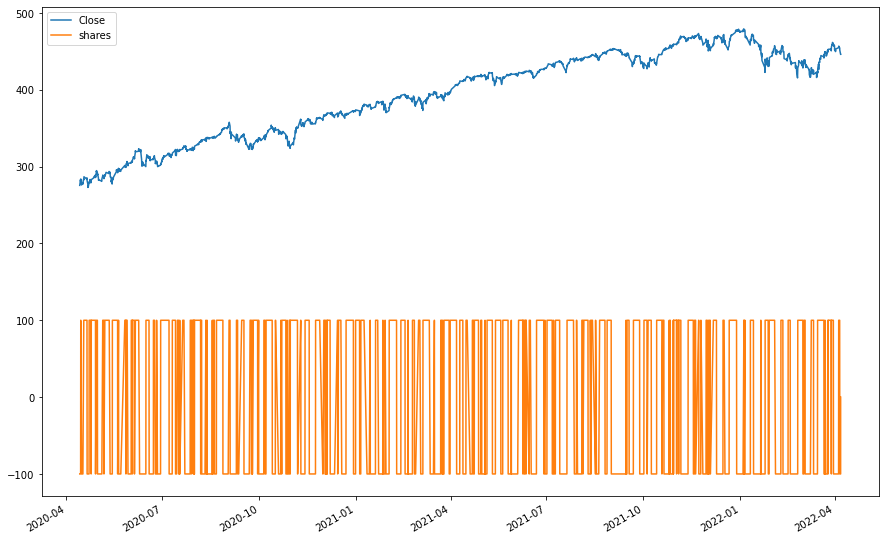

In [86]:
#graphing positions over time

macd_df.plot(y=["Close", "shares"], kind = "line", figsize = (15,10))

In [90]:
# Try a long-only strategy using MACD to time entries/exits

# Initialize trade_type column to track buys and sells
macd_df["side"] = np.nan

# Initialize a cost/proceeds column for recording trade metrics
macd_df["cost/proceeds"] = np.nan

# Initialize share size and accumulated shares
share_size = 100
accumulated_shares = 0

# Initialize variable to hold previous price
previous_price = 0

# Loop through the Pandas DataFrame and initiate a trade at each iteration 
for index, row in macd_df.iterrows():
    
    # initiate a buy on the first trading day
    if previous_price == 0:
        macd_df.loc[index, "side"] = "buy"
        macd_df.loc[index, "cost/proceeds"] = -(row["Close"] * share_size)
        accumulated_shares += share_size
        macd_df.loc[index, "shares"] = accumulated_shares
    # buy if the current day's price is less than the previous day's price
    elif row["MACD_Entry/Exit"] > 0 and share_size == 0:
        macd_df.loc[index, "side"] = "buy"
        macd_df.loc[index, "cost/proceeds"] = -(row["Close"] * share_size)
        accumulated_shares += share_size
        macd_df.loc[index, "shares"] = accumulated_shares
    # sell if the current day's price is greater than the previous day's price
    elif row["MACD_Entry/Exit"] < 0:
        macd_df.loc[index, "side"] = "sell" 
        macd_df.loc[index, "cost/proceeds"] = (row["Close"] * accumulated_shares)
        accumulated_shares = 0
        macd_df.loc[index, "shares"] = accumulated_shares
    # hold if the current day's price is equal to the previous day's price
    else:
        macd_df.loc[index, "side"] = "hold"
        macd_df.loc[index, "shares"] = accumulated_shares
    # update the previous_price to the current row's price
    previous_price = row["Close"]
    

# Review the DataFrame
macd_df.tail()

,Close,MACDh_12_26_9,MACD_Entry/Exit,side,cost/proceeds,shares
2022-04-05 13:30:00-04:00,452.950012,-0.092791,0.0,hold,NaN,0.0
2022-04-05 14:30:00-04:00,451.400208,-0.242741,0.0,hold,NaN,0.0
2022-04-05 15:30:00-04:00,451.100006,-0.341616,0.0,hold,NaN,0.0
2022-04-06 09:30:00-04:00,445.964996,-0.711062,0.0,hold,NaN,0.0
2022-04-06 09:57:16-04:00,445.980011,-0.900447,0.0,hold,NaN,0.0


In [91]:
#let's see how much money our system made!

total_profit_loss = macd_df["cost/proceeds"].sum()

print(f"Using our algorithm made ${total_profit_loss}!")

Using our algorithm made $48.9898681640625!
